# Plot the ROC curve

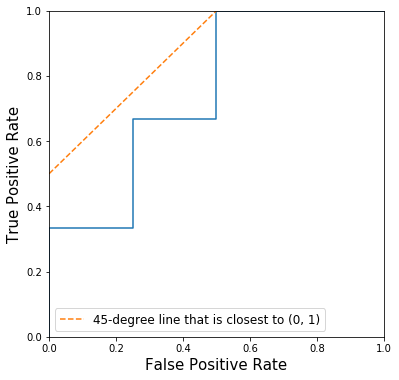

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

y_prob = np.array([0.95, 0.85, 0.8, 0.7, 0.55, 0.45, 0.4, 0.3, 0.2, 0.1], dtype='float32')
y_label = np.array([1, 1, 0, 1, 1, 0, 1, 1, 0, 0], dtype='float32')

#fpr, tpr, thresholds = roc_curve(y_label, y_prob)
plt.figure(figsize=(6,6))
#plt.plot(fpr, tpr)
sen = np.array([1.0, 1.0, 1.0, 5/6, 4/6, 4/6, 0.5, 2/6, 2/6, 1/6, 0], dtype='float32')
spe = np.array([0.0, 0.25, 0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 1.0, 1.0, 1.0], dtype='float32')
plt.plot(1-spe, sen)
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.plot([0, 0.5],[0.5,1.0], '--', label='45-degree line that is closest to (0, 1)')
plt.legend(fontsize=12)
plt.savefig('./figures/ROC.png')
plt.show()

plt.close()

# Visualize the predictions of 1NN on a 2D grid 

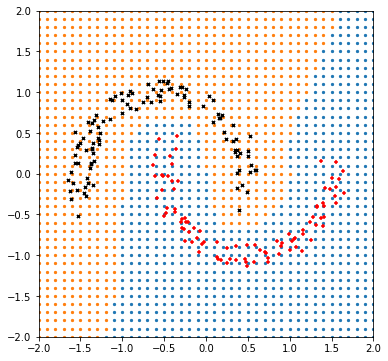

In [1]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np

def read_txt(filename):
    x = []
    y = [] 
    with open(filename, 'r') as data:
        lines = data.readlines()
        for line in lines:
            x.append([float(line.split(' ')[0]), float(line.split(' ')[1])])
            y.append(int(line.split()[2]))
    return x, y
        
data, classes = read_txt('./data/D2z.txt')
knn = KNeighborsClassifier(n_neighbors=1) # Euclidean distance
knn.fit(data, classes)

# prediction
x1 = np.arange(-2, 2.1, 0.1).reshape(-1, 1)
x2 = np.arange(-2, 2.1, 0.1).reshape(-1, 1)
x1_grid, x2_grid = np.meshgrid(x1, x2) 
x1_grid = x1_grid.reshape(-1,1)
x2_grid = x2_grid.reshape(-1,1)
test_data = list(np.concatenate((x1_grid, x2_grid), axis=1))
y_pred = knn.predict(test_data)

plt.figure(figsize=(6,6))
plt.scatter(x1_grid[y_pred==0], x2_grid[y_pred==0], s=5, label='Class: 0')
plt.scatter(x1_grid[y_pred==1], x2_grid[y_pred==1], s=5, label='Class: 1')
plt.scatter(np.array(data)[np.array(classes)==0,0], np.array(data)[np.array(classes)==0,1], \
            c='r',s=10, marker='+', label='Training data, Class: 0')
plt.scatter(np.array(data)[np.array(classes)==1,0], np.array(data)[np.array(classes)==1,1], \
            c='k',s=10, marker='x', label='Training data, Class: 1')

plt.xlim([-2, 2])
plt.ylim([-2, 2])
#plt.legend(fontsize=10)
plt.savefig('./figures/KNN.png')
plt.show()           


# Run 5-fold CV for 1NN

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

T = pd.read_csv('./data/emails.csv')
data = T[T.columns[1:3001]].to_numpy() 
classes = np.array(T.Prediction.tolist()) 
k = 1
acc_list = []
precision_list = []
recall_list = []
for ii in range(5): # 5-fold CV
    test_data = data[:1000, :]
    train_data = data[1000:, :]
    test_classes = classes[:1000]
    train_classes = classes[1000:] 
    
    knn = KNeighborsClassifier(n_neighbors=k) # Euclidean distance
    knn.fit(train_data, train_classes)
    test_pred = knn.predict(test_data)
    test_pred_prob = knn.predict_proba(test_data)
    auc_knn = roc_auc_score(test_classes, test_pred_prob[:,1])
    data = np.roll(data, -1000, axis=0)
    classes = np.roll(classes, -1000)
    
    acc_list.append(np.sum(test_classes == test_pred) / len(test_classes))
    precision_list.append(np.sum(test_pred[test_classes==1]) / np.sum(test_pred==1))
    recall_list.append(np.sum(test_pred[test_classes==1]) / np.sum(test_classes==1))
    
    print("fold {}, AUC: {:.3f}, Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%\n".format(ii+1, \
                                                                                auc_knn, \
                                                                                acc_list[ii]*100, \
                                                                                precision_list[ii]*100, \
                                                                                recall_list[ii]*100))

fold 1, AUC: 0.822, Accuracy: 82.40%, Precision: 65.27%, Recall: 81.75%

fold 2, AUC: 0.859, Accuracy: 85.50%, Precision: 68.97%, Recall: 86.64%

fold 3, AUC: 0.854, Accuracy: 86.20%, Precision: 72.26%, Recall: 83.45%

fold 4, AUC: 0.844, Accuracy: 85.40%, Precision: 72.16%, Recall: 81.97%

fold 5, AUC: 0.772, Accuracy: 77.60%, Precision: 60.68%, Recall: 76.14%



In [2]:
print("Average Accuracy: {:.2f}%".format(np.mean(acc_list)*100))
print("Average Precision: {:.2f}%".format(np.mean(precision_list)*100))
print("Average Recall: {:.2f}%".format(np.mean(recall_list)*100))

Average Accuracy: 83.42%
Average Precision: 67.86%
Average Recall: 81.99%


# Average accuracy changes with k 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

T = pd.read_csv('./data/emails.csv')
data = T[T.columns[1:3001]].to_numpy() 
classes = np.array(T.Prediction.tolist()) 
acc_k = []
precision_k = []
recall_k = [] 
for k in [1, 3, 5, 7, 10]:
    acc_list = []
    precision_list = []
    recall_list = []
    for ii in range(5): # 5-fold CV
        test_data = data[:1000, :]
        train_data = data[1000:, :]
        test_classes = classes[:1000]
        train_classes = classes[1000:] 
    
        knn = KNeighborsClassifier(n_neighbors=k) # Euclidean distance
        knn.fit(train_data, train_classes)
        test_pred = knn.predict(test_data)
        data = np.roll(data, -1000, axis=0)
        classes = np.roll(classes, -1000)
    
        acc_list.append(np.sum(test_classes == test_pred) / len(test_classes))
        precision_list.append(np.sum(test_pred[test_classes==1]) / np.sum(test_pred==1))
        recall_list.append(np.sum(test_pred[test_classes==1]) / np.sum(test_classes==1))
    acc_k.append(np.mean(acc_list))
    precision_k.append(np.mean(precision_list))
    recall_k.append(np.mean(recall_list)) 

[0.8342, 0.8413999999999999, 0.8418000000000001, 0.8452, 0.8552]


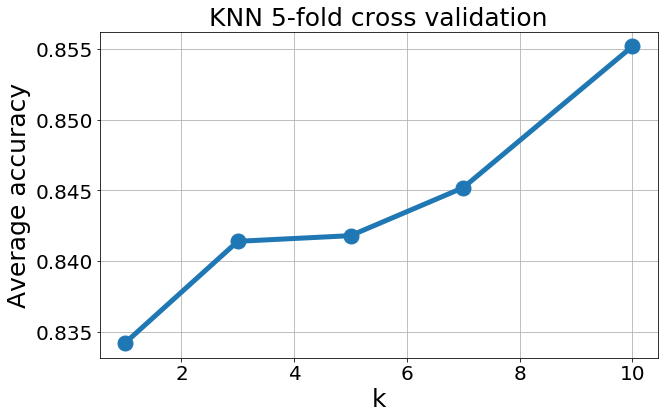

In [4]:
print(acc_k)
plt.figure(figsize=(10,6))
plt.plot([1,3,5,7,10], acc_k, '-o', linewidth=5, markersize=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid('on')
plt.xlabel('k', fontsize=25)
plt.ylabel('Average accuracy', fontsize=25)
plt.title('KNN 5-fold cross validation', fontsize=25)
plt.savefig('./figures/knn_cv.png')
plt.show()

# Logistic regression

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 

class logistic_regression():
    def __init__(self, num_feats): 
        W =  np.random.normal(0, np.sqrt(2/num_feats), (num_feats, 1)) 
        # initialize weights with Gaussian distribution
        W[0] = 0 # initialize bias as a constant 0 
        self.W = W
        #self.alpha = alpha
        
    def sigmoid(self, x):
        return 1/(1 + np.exp(-x))
    
    def forward(self, x):
        # include bias as the 1st dimension
        z = np.matmul(x, self.W) # (N, num_feats) (num_feats, 1) = (N, 1)
        return self.sigmoid(z) 
    
    def backward(self, y_target, y_pred, x, alpha): 
        dw = np.mean((y_pred - y_target)* x, 0) # (N,1) * (N, num_feats) = (N, num_feats)
        self.W -= alpha * dw.reshape(-1,1)
    
    def loss(self, y_target, y_pred):
        return np.mean(-y_target*np.log(y_pred)-(1-y_target)*np.log(1-y_pred)) 
    
    def train(self, data, classes, num_epochs, alpha=0.1):
        #loss_list = []
        for epoch in tqdm(range(num_epochs)):
            y_pred = self.forward(data)
            loss = self.loss(classes, y_pred)
            self.backward(classes, y_pred, data, alpha)
            #loss_list.append(loss)
    
    def predict(self, data):
        return self.forward(data)

In [17]:
import pandas as pd 
num_epochs = 200 
T = pd.read_csv('./data/emails.csv')
data = T[T.columns[1:3001]].to_numpy().astype('float32')
data /= np.sum(data, 1, keepdims=True) # normalize counts to frequency 
data = np.concatenate((np.ones((data.shape[0],1)), data*100), axis=1) # add bias at the 1st dim 
classes = np.array(T.Prediction.tolist()).reshape(-1,1) 
num_feats = data.shape[1] # include bias

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
acc_list = []
precision_list = []
recall_list = []
for ii in range(5): # 5-fold CV
    test_data = data[:1000, :]
    train_data = data[1000:, :]
    test_classes = classes[:1000]
    train_classes = classes[1000:] 
    model = logistic_regression(num_feats)
    model.train(train_data, train_classes, 200, 0.1)
    model.train(train_data, train_classes, 100, 0.01)
    test_pred_prob = model.predict(test_data)
    test_pred = test_pred_prob > 0.5
    print('AUROC: {:.3f}'.format(roc_auc_score(test_classes, test_pred_prob)))
    
    data = np.roll(data, -1000, axis=0)
    classes = np.roll(classes, -1000)
    
    acc_list.append(np.sum(test_classes == test_pred) / len(test_classes))
    precision_list.append(np.sum(test_pred[test_classes==1]) / np.sum(test_pred==1))
    recall_list.append(np.sum(test_pred[test_classes==1]) / np.sum(test_classes==1))
    
    print("fold {}, Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%\n".format(ii+1, \
                                                                                acc_list[ii]*100, \
                                                                                precision_list[ii]*100, \
                                                                                recall_list[ii]*100))

  0%|          | 0/200 [00:00<?, ?it/s]

AUROC: 0.949
fold 1, Accuracy: 89.60%, Precision: 80.89%, Recall: 83.16%



  1%|          | 2/200 [00:00<00:14, 13.86it/s]

AUROC: 0.952
fold 2, Accuracy: 89.90%, Precision: 79.93%, Recall: 84.84%



  1%|          | 2/200 [00:00<00:13, 14.56it/s]

AUROC: 0.947
fold 3, Accuracy: 90.60%, Precision: 86.26%, Recall: 79.58%



  1%|          | 2/200 [00:00<00:13, 14.72it/s]

AUROC: 0.953
fold 4, Accuracy: 87.90%, Precision: 82.89%, Recall: 74.15%



100%|██████████| 100/100 [00:06<00:00, 14.36it/s]

AUROC: 0.898
fold 5, Accuracy: 82.30%, Precision: 73.29%, Recall: 66.34%



In [5]:
print("Average Accuracy: {:.2f}%".format(np.mean(acc_list)*100))
print("Average Precision: {:.2f}%".format(np.mean(precision_list)*100))
print("Average Recall: {:.2f}%".format(np.mean(recall_list)*100))

Average Accuracy: 88.06%
Average Precision: 80.65%
Average Recall: 77.61%


# Compute ROC of KNN (k=5) and logistic regression 


100%|██████████| 100/100 [00:06<00:00, 14.49it/s]


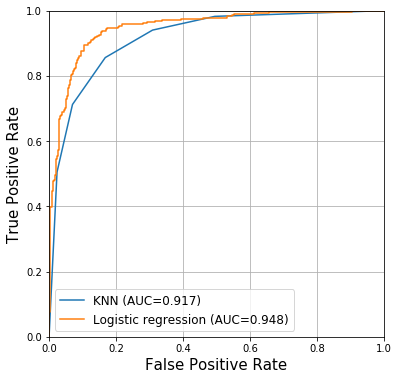

In [4]:
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from tqdm import * 

T = pd.read_csv('./data/emails.csv')
data = T[T.columns[1:3001]].to_numpy() 
classes = np.array(T.Prediction.tolist()) 
test_data = data[:1000, :]
train_data = data[1000:, :]
test_classes = classes[:1000]
train_classes = classes[1000:] 

# KNN k=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_data, train_classes)
test_pred = knn.predict_proba(test_data)
#test_pred = knn.predict(test_data)
fpr, tpr, thresholds = roc_curve(test_classes, test_pred[:,1])
AUC_knn = roc_auc_score(test_classes, test_pred[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='KNN (AUC={:.3f})'.format(AUC_knn))

# logistic regression
data = T[T.columns[1:3001]].to_numpy().astype('float32')
data /= np.sum(data, 1, keepdims=True) # normalize counts to frequency 
data = np.concatenate((np.ones((data.shape[0],1)), data*100), axis=1) # add bias at the 1st dim 
classes = np.array(T.Prediction.tolist()).reshape(-1,1) 
test_data = data[:1000, :]
train_data = data[1000:, :]
test_classes = classes[:1000]
train_classes = classes[1000:] 
num_feats = data.shape[1] # include bias

model = logistic_regression(num_feats)
model.train(train_data, train_classes, 200, 0.1)
model.train(train_data, train_classes, 100, 0.01)
test_pred_prob = model.predict(test_data)
fpr, tpr, thresholds = roc_curve(test_classes, test_pred_prob)
AUC_logistic = roc_auc_score(test_classes, test_pred_prob)
plt.plot(fpr, tpr, label='Logistic regression (AUC={:.3f})'.format(AUC_logistic))

plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(fontsize=12)
plt.grid('on')
plt.savefig('./figures/roc_knn_logistic_regression.png')
plt.show()